In [ ]:
# %%
"""
CPI to SPIN Conversion Test Notebook
Testing with loop examples and visualization
"""

import sys
import os
import json
import traceback
import graphviz
from IPython.display import display

# Add paths
sys.path.append('')
sys.path.append('..')
sys.path.append('')

print("Setting up CPI to SPIN conversion test environment...")

# %%
# Import the translation module
from spin_direct.translation import SPINtoPRISM, TransitionType

print(f"Successfully imported SPIN translation module")
print(f"Available transition types: {[t.value for t in TransitionType]}")


In [ ]:
class CPIToSPINConverter:
    """
    Converts CPI (Control Process Interface) format to SPIN model format.
    
    Efficient translation following BPMN+CPI pattern:
    - Each region adds at most 2 places (entry and exit)
    - Sequences add no intermediate places (direct connection)
    - Task input places get the task duration, all others have duration 0
    """
    
    def __init__(self):
        self.spin_model = SPINtoPRISM()
        self.place_counter = 0
        self.transition_counter = 0
        
    def get_next_place_name(self, prefix="p"):
        """Generate next place name"""
        name = f"{prefix}{self.place_counter}"
        self.place_counter += 1
        return name
        
    def get_next_transition_name(self, prefix="t"):
        """Generate next transition name"""
        name = f"{prefix}{self.transition_counter}"
        self.transition_counter += 1
        return name
    
    def convert_cpi_to_spin(self, cpi_dict):
        """
        Main conversion function from CPI dictionary to SPIN model.
        """
        # Reset counters
        self.place_counter = 0
        self.transition_counter = 0
        self.spin_model = SPINtoPRISM()
        
        # Create initial place (duration 0)
        start_place = self.get_next_place_name("start")
        self.spin_model.add_place(start_place, duration=0, is_initial=True)
        
        # Create end place (duration 0)
        end_place = self.get_next_place_name("end")
        self.spin_model.add_place(end_place, duration=0)
        
        # Convert the root region
        self._convert_region(cpi_dict, start_place, end_place)
        
        return self.spin_model
    
    def _convert_region(self, region, input_place, output_place):
        """Recursively convert a CPI region to SPIN places and transitions."""
        region_type = region['type']
        
        if region_type == 'task':
            self._convert_task(region, input_place, output_place)
        elif region_type == 'sequence':
            self._convert_sequence(region, input_place, output_place)
        elif region_type == 'parallel':
            self._convert_parallel(region, input_place, output_place)
        elif region_type == 'choice':
            self._convert_choice(region, input_place, output_place)
        elif region_type == 'nature':
            self._convert_nature(region, input_place, output_place)
        elif region_type == 'loop':
            self._convert_loop(region, input_place, output_place)
        else:
            raise ValueError(f"Unknown region type: {region_type}")
    
    def _convert_task(self, task_region, input_place, output_place):
        """Convert a task region to SPIN task transition
        
        Pattern: input_place --[task_transition]--> output_place
        """
        transition_name = self.get_next_transition_name(f"task{task_region['id']}")
        
        # Set the duration on the input place (where time is spent)
        if input_place in self.spin_model.places:
            self.spin_model.places[input_place].duration = task_region['duration']
        else:
            self.spin_model.add_place(input_place, duration=task_region['duration'])
        
        # Extract impact vector
        impacts = task_region.get('impacts', {})
        impact_vector = [impacts[k] for k in sorted(impacts.keys())] if impacts else []
        
        # Create task transition
        self.spin_model.add_transition(
            transition_name,
            TransitionType.TASK,
            [input_place],
            [output_place],
            impact_vector=impact_vector
        )
    
    def _convert_sequence(self, seq_region, input_place, output_place):
        """Convert a sequence region (head then tail)
        
        Pattern: input_place --> head --> intermediate --> tail --> output_place
        Adds 0 places (reuses input/output, creates 1 intermediate)
        """
        # Create only one intermediate place between head and tail
        intermediate_place = self.get_next_place_name(f"seq{seq_region['id']}_mid")
        self.spin_model.add_place(intermediate_place, duration=0)
        
        # Convert head and tail
        self._convert_region(seq_region['head'], input_place, intermediate_place)
        self._convert_region(seq_region['tail'], intermediate_place, output_place)
    
    def _convert_parallel(self, par_region, input_place, output_place):
        """Convert a parallel region (concurrent execution)
        
        Pattern: input --[split]--> branch1 --[merge]--> output
                               \--> branch2 ----/
        Adds 2 places (one for each branch end)
        """
        split_name = self.get_next_transition_name(f"split{par_region['id']}")
        merge_name = self.get_next_transition_name(f"merge{par_region['id']}")
        
        # Create end places for each branch
        first_end = self.get_next_place_name(f"par{par_region['id']}_first_end")
        second_end = self.get_next_place_name(f"par{par_region['id']}_second_end")
        
        self.spin_model.add_place(first_end, duration=0)
        self.spin_model.add_place(second_end, duration=0)
        
        # Create start places for each branch
        first_start = self.get_next_place_name(f"par{par_region['id']}_first_start")
        second_start = self.get_next_place_name(f"par{par_region['id']}_second_start")
        
        self.spin_model.add_place(first_start, duration=0)
        self.spin_model.add_place(second_start, duration=0)
        
        # Split transition
        self.spin_model.add_transition(
            split_name,
            TransitionType.PARALLEL_SPLIT,
            [input_place],
            [first_start, second_start]
        )
        
        # Convert both branches
        self._convert_region(par_region['first_split'], first_start, first_end)
        self._convert_region(par_region['second_split'], second_start, second_end)
        
        # Merge transition
        self.spin_model.add_transition(
            merge_name,
            TransitionType.PARALLEL_MERGE,
            [first_end, second_end],
            [output_place]
        )
    
    def _convert_choice(self, choice_region, input_place, output_place):
        """Convert a choice region (non-deterministic choice)
        
        Pattern: input --[choice]--> branch1 --[single]--> output
                               \--> branch2 --[single]---/
        Adds 2 places (entry for each branch)
        """
        choice_name = self.get_next_transition_name(f"choice{choice_region['id']}")
        
        # Create entry places for each branch
        true_entry = self.get_next_place_name(f"choice{choice_region['id']}_true")
        false_entry = self.get_next_place_name(f"choice{choice_region['id']}_false")
        
        self.spin_model.add_place(true_entry, duration=0)
        self.spin_model.add_place(false_entry, duration=0)
        
        # Choice transition
        self.spin_model.add_transition(
            choice_name,
            TransitionType.CHOICE,
            [input_place],
            [true_entry, false_entry]
        )
        
        # Convert both branches directly to output
        self._convert_region(choice_region['true'], true_entry, output_place)
        self._convert_region(choice_region['false'], false_entry, output_place)
    
    def _convert_nature(self, nature_region, input_place, output_place):
        """Convert a nature region (probabilistic choice)
        
        Pattern: input --[nature_prob]--> branch1 --[single]--> output
                                     \--> branch2 --[single]---/
        Adds 2 places (entry for each branch)
        """
        nature_name = self.get_next_transition_name(f"nature{nature_region['id']}")
        
        # Create entry places for each branch
        true_entry = self.get_next_place_name(f"nature{nature_region['id']}_true")
        false_entry = self.get_next_place_name(f"nature{nature_region['id']}_false")
        
        self.spin_model.add_place(true_entry, duration=0)
        self.spin_model.add_place(false_entry, duration=0)
        
        # Nature transition with probability
        self.spin_model.add_transition(
            nature_name,
            TransitionType.NATURE,
            [input_place],
            [true_entry, false_entry],
            probability=nature_region['probability']
        )
        
        # Convert both branches directly to output
        self._convert_region(nature_region['true'], true_entry, output_place)
        self._convert_region(nature_region['false'], false_entry, output_place)
    
    def _convert_loop(self, loop_region, input_place, output_place):
        """Convert a loop region (probabilistic repetition)
        
        Pattern: input --> child_entry --> [child] --> child_exit --> decision
                                                           ^              |
                                                           |    [repeat]  |
                                                           +------<-------+
                                                                          |
                                                                    [exit]|
                                                                          v
                                                                      output
        Adds 2 places (child entry and decision point)
        """
        # Create places for loop structure
        child_entry = self.get_next_place_name(f"loop{loop_region['id']}_child_entry")
        decision_place = self.get_next_place_name(f"loop{loop_region['id']}_decision")
        
        self.spin_model.add_place(child_entry, duration=0)
        self.spin_model.add_place(decision_place, duration=0)
        
        # Initial transition to child (first execution)
        init_trans = self.get_next_transition_name(f"loop{loop_region['id']}_init")
        self.spin_model.add_transition(
            init_trans,
            TransitionType.SINGLE,
            [input_place],
            [child_entry]
        )
        
        # Convert child region to decision point
        self._convert_region(loop_region['child'], child_entry, decision_place)
        
        # Decision transition: repeat or exit
        decision_trans = self.get_next_transition_name(f"loop{loop_region['id']}_decision")
        self.spin_model.add_transition(
            decision_trans,
            TransitionType.NATURE,
            [decision_place],
            [child_entry, output_place],  # repeat or exit
            probability=loop_region['probability']  # probability of repeating
        )

In [38]:

# %%
def create_cpi_visualization(cpi_dict, title="CPI Process"):
    """Create a Graphviz visualization of the CPI structure"""
    dot = graphviz.Digraph(comment=title, format='png')
    dot.attr(rankdir='LR')
    dot.attr('node', fontsize='10', fontname='Arial')
    dot.attr('edge', fontsize='8', fontname='Arial')
    
    def add_cpi_node(region):
        """Recursively add nodes for CPI regions"""
        node_id = f"{region['type']}{region['id']}"
        
        # Customize node appearance based on type
        if region['type'] == 'task':
            impacts_str = ', '.join([f"{k}:{v}" for k,v in region.get('impacts', {}).items()])
            label = f"{node_id}\\ndur:{region['duration']}\\n{impacts_str}"
            dot.node(node_id, label, shape='box', style='filled', color='lightgreen')
        elif region['type'] == 'nature':
            label = f"{node_id}\\np={region['probability']}"
            dot.node(node_id, label, shape='diamond', style='filled', color='lightcoral')
        elif region['type'] == 'choice':
            dot.node(node_id, node_id, shape='diamond', style='filled', color='lightblue')
        elif region['type'] == 'sequence':
            dot.node(node_id, node_id, shape='box', style='filled', color='lightyellow')
        elif region['type'] == 'parallel':
            dot.node(node_id, node_id, shape='box', style='filled', color='lightpink')
        elif region['type'] == 'loop':
            label = f"{node_id}\\nrep_p={region['probability']}"
            dot.node(node_id, label, shape='box', style='filled', color='lightgray')
        else:
            dot.node(node_id, node_id, shape='ellipse')
        
        # Add edges based on region type
        if region['type'] == 'sequence':
            head_id = f"{region['head']['type']}{region['head']['id']}"
            tail_id = f"{region['tail']['type']}{region['tail']['id']}"
            dot.edge(node_id, head_id, label='head')
            dot.edge(node_id, tail_id, label='tail')
            add_cpi_node(region['head'])
            add_cpi_node(region['tail'])
        elif region['type'] == 'parallel':
            first_id = f"{region['first_split']['type']}{region['first_split']['id']}"
            second_id = f"{region['second_split']['type']}{region['second_split']['id']}"
            dot.edge(node_id, first_id, label='first')
            dot.edge(node_id, second_id, label='second')
            add_cpi_node(region['first_split'])
            add_cpi_node(region['second_split'])
        elif region['type'] in ['choice', 'nature']:
            true_id = f"{region['true']['type']}{region['true']['id']}"
            false_id = f"{region['false']['type']}{region['false']['id']}"
            dot.edge(node_id, true_id, label='true')
            dot.edge(node_id, false_id, label='false')
            add_cpi_node(region['true'])
            add_cpi_node(region['false'])
        elif region['type'] == 'loop':
            child_id = f"{region['child']['type']}{region['child']['id']}"
            dot.edge(node_id, child_id, label='child')
            dot.edge(child_id, node_id, label='repeat', style='dashed', color='gray')
            add_cpi_node(region['child'])
    
    add_cpi_node(cpi_dict)
    return dot

def create_spin_visualization(spin_model: SPINtoPRISM, title="SPIN Model"):
    """Create a Graphviz visualization of the SPIN model"""
    dot = graphviz.Digraph(comment=title, format='png')
    dot.attr(rankdir='LR')
    dot.attr('node', fontsize='10', fontname='Arial')
    dot.attr('edge', fontsize='8', fontname='Arial')
    
    # Add places
    for name, place in spin_model.places.items():
        if place.is_initial:
            shape = 'doublecircle'
            color = 'lightblue'
            style = 'filled'
        else:
            shape = 'circle'
            color = 'lightgray'
            style = 'filled'
            
        label = f"{name}\\nd={place.duration}"
        dot.node(name, label, shape=shape, color=color, style=style)
    
    # Add transitions and connections
    for transition in spin_model.transitions:
        # Create transition node with type-specific styling
        if transition.type.value == 'nature':
            label = f"{transition.name}\\np={transition.probability}"
            color = 'lightcoral'
            style = 'filled'
        elif transition.type.value == 'choice':
            label = f"{transition.name}\\n(choice)"
            color = 'lightblue'
            style = 'filled'
        elif transition.type.value == 'task':
            impact_str = str(transition.impact_vector) if transition.impact_vector else ""
            label = f"{transition.name}\\n{impact_str}"
            color = 'lightgreen'
            style = 'filled'
        elif transition.type.value == 'parallel_split':
            label = f"{transition.name}\\n(||split)"
            color = 'lightyellow'
            style = 'filled'
        elif transition.type.value == 'parallel_merge':
            label = f"{transition.name}\\n(||merge)"
            color = 'lightyellow'
            style = 'filled'
        else:
            label = transition.name
            color = 'white'
            style = 'filled'
            
        t_node = f"t_{transition.name}"
        dot.node(t_node, label, shape='box', color=color, style=style)
        
        # Add edges from input places to transition
        for p_in in transition.input_places:
            dot.edge(p_in, t_node, arrowsize='0.7')
            
        # Add edges from transition to output places
        for p_out in transition.output_places:
            dot.edge(t_node, p_out, arrowsize='0.7')
    
    return dot

print("Visualization functions defined successfully!")


Visualization functions defined successfully!


In [39]:

# %%
# Load the CPI file (correcting the typo from 'tets_loop1' to 'test_loop1')
cpi_file_path = '../CPIs/choice.cpi'

print(f"Loading CPI file: {cpi_file_path}")

try:
    with open(cpi_file_path, 'r') as f:
        cpi_dict = json.load(f)
    
    print("✓ CPI file loaded successfully!")
    print(f"Root region type: {cpi_dict['type']}")
    print(f"Root region ID: {cpi_dict['id']}")
    
    # Pretty print the CPI structure
    print("\nCPI Structure:")
    print("=" * 50)
    print(json.dumps(cpi_dict, indent=2))
    
except FileNotFoundError:
    print(f"❌ File not found: {cpi_file_path}")
    print("Available files in CPIs directory:")
    try:
        for f in os.listdir('../CPIs'):
            if f.endswith('.cpi'):
                print(f"  - {f}")
    except:
        print("  Could not list CPIs directory")
except Exception as e:
    print(f"❌ Error loading CPI file: {e}")
    traceback.print_exc()

# %%
# Analyze CPI structure
def analyze_cpi_structure(region, depth=0):
    """Recursively analyze the CPI structure"""
    indent = "  " * depth
    region_type = region['type']
    region_id = region['id']
    
    print(f"{indent}{region_type}{region_id}")
    
    if region_type == 'task':
        print(f"{indent}  duration: {region['duration']}")
        if 'impacts' in region:
            print(f"{indent}  impacts: {region['impacts']}")
    elif region_type == 'loop':
        print(f"{indent}  repeat_probability: {region['probability']}")
        print(f"{indent}  child:")
        analyze_cpi_structure(region['child'], depth + 2)
    elif region_type == 'sequence':
        print(f"{indent}  head:")
        analyze_cpi_structure(region['head'], depth + 2)
        print(f"{indent}  tail:")
        analyze_cpi_structure(region['tail'], depth + 2)
    elif region_type == 'parallel':
        print(f"{indent}  first_split:")
        analyze_cpi_structure(region['first_split'], depth + 2)
        print(f"{indent}  second_split:")
        analyze_cpi_structure(region['second_split'], depth + 2)
    elif region_type in ['choice', 'nature']:
        if region_type == 'nature':
            print(f"{indent}  probability: {region['probability']}")
        print(f"{indent}  true:")
        analyze_cpi_structure(region['true'], depth + 2)
        print(f"{indent}  false:")
        analyze_cpi_structure(region['false'], depth + 2)

print("\nCPI Structure Analysis:")
print("=" * 50)
if 'cpi_dict' in locals():
    analyze_cpi_structure(cpi_dict)

# %%
# Convert CPI to SPIN
print("Converting CPI to SPIN...")
print("=" * 50)

try:
    converter = CPIToSPINConverter()
    spin_model = converter.convert_cpi_to_spin(cpi_dict)
    
    print("✓ Conversion successful!")
    print("\nSPIN Model Summary:")
    print("-" * 30)
    spin_model.print_model_summary()
    
except Exception as e:
    print(f"❌ Conversion failed: {e}")
    traceback.print_exc()


Loading CPI file: ../CPIs/choice.cpi
✓ CPI file loaded successfully!
Root region type: choice
Root region ID: 5

CPI Structure:
{
  "type": "choice",
  "id": 5,
  "true": {
    "type": "task",
    "id": 6,
    "duration": 2,
    "impacts": {
      "impact_1": 0.3,
      "impact_2": 0.4
    }
  },
  "false": {
    "type": "task",
    "id": 7,
    "duration": 3,
    "impacts": {
      "impact_1": 0.5,
      "impact_2": 0.5
    }
  }
}

CPI Structure Analysis:
choice5
  true:
    task6
      duration: 2
      impacts: {'impact_1': 0.3, 'impact_2': 0.4}
  false:
    task7
      duration: 3
      impacts: {'impact_1': 0.5, 'impact_2': 0.5}
Converting CPI to SPIN...
✓ Conversion successful!

SPIN Model Summary:
------------------------------
=== SPIN to PRISM Translation ===
Places: 4
  choice5_false3: duration=3
  choice5_true2: duration=2
  end1: duration=0
  start0: duration=0 (INITIAL)

Transitions: 3
  choice50 (choice): ['start0'] -> ['choice5_true2', 'choice5_false3']
  task61 (task):


Creating visualizations...
✓ CPI visualization created
✓ SPIN visualization created

CPI Structure Visualization:


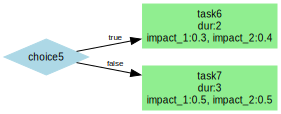


SPIN Model Visualization:


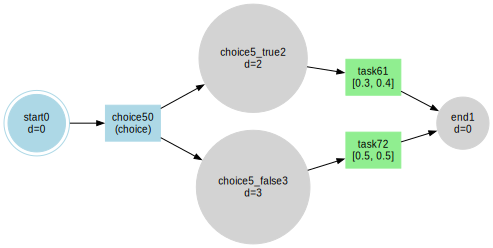

In [40]:

# %%
# Create visualizations
print("\nCreating visualizations...")
print("=" * 50)

try:
    # Create CPI visualization
    cpi_viz = create_cpi_visualization(cpi_dict, "CPI: Loop Example")
    print("✓ CPI visualization created")
    
    # Create SPIN visualization  
    spin_viz = create_spin_visualization(spin_model, "SPIN: Loop Example")
    print("✓ SPIN visualization created")
    
    # Display visualizations (if in Jupyter)
    try:
        print("\nCPI Structure Visualization:")
        display(cpi_viz)
        
        print("\nSPIN Model Visualization:")
        display(spin_viz)
    except NameError:
        # Not in Jupyter, save to files instead
        print("Saving visualizations to files...")
        
        # Save CPI visualization
        cpi_output = 'test_loop1_cpi'
        cpi_viz.render(cpi_output, cleanup=True)
        print(f"CPI visualization saved to: {cpi_output}.png")
        
        # Save SPIN visualization
        spin_output = 'test_loop1_spin'
        spin_viz.render(spin_output, cleanup=True)
        print(f"SPIN visualization saved to: {spin_output}.png")

except Exception as e:
    print(f"❌ Visualization failed: {e}")
    traceback.print_exc()


In [41]:

# %%
# Generate PRISM model
print("\nGenerating PRISM model...")
print("=" * 50)

try:
    prism_model = spin_model.generate_prism_model()
    
    print("✓ PRISM model generated successfully!")
    
    # Show model statistics
    lines = prism_model.split('\n')
    words = prism_model.split()
    
    print(f"Model statistics:")
    print(f"  Lines: {len(lines)}")
    print(f"  Words: {len(words)}")
    print(f"  Characters: {len(prism_model)}")
    
    # Show first 20 lines
    print(f"\nFirst 20 lines of PRISM model:")
    print("-" * 40)
    for i, line in enumerate(lines[:20]):
        print(f"{i+1:2d}: {line}")
    
    if len(lines) > 20:
        print(f"... ({len(lines) - 20} more lines)")

except Exception as e:
    print(f"❌ PRISM generation failed: {e}")
    traceback.print_exc()

# %%
# Save PRISM model
print("\nSaving PRISM model...")
print("=" * 50)

try:
    output_file = 'test_loop1_spin.nm'
    with open(output_file, 'w') as f:
        f.write(prism_model)
    
    print(f"✓ PRISM model saved to: {output_file}")
    
    # Verify file was created
    if os.path.exists(output_file):
        file_size = os.path.getsize(output_file)
        print(f"File size: {file_size} bytes")
    else:
        print("❌ Warning: File was not created")

except Exception as e:
    print(f"❌ Save failed: {e}")
    traceback.print_exc()

# %%
# Analysis of conversion results
print("\nConversion Analysis:")
print("=" * 50)

# Count regions in CPI
def count_cpi_regions(region):
    count = 1
    if region['type'] == 'sequence':
        count += count_cpi_regions(region['head'])
        count += count_cpi_regions(region['tail'])
    elif region['type'] == 'parallel':
        count += count_cpi_regions(region['first_split'])
        count += count_cpi_regions(region['second_split'])
    elif region['type'] in ['choice', 'nature']:
        count += count_cpi_regions(region['true'])
        count += count_cpi_regions(region['false'])
    elif region['type'] == 'loop':
        count += count_cpi_regions(region['child'])
    return count

# Count tasks in CPI
def count_cpi_tasks(region):
    count = 1 if region['type'] == 'task' else 0
    if region['type'] == 'sequence':
        count += count_cpi_tasks(region['head'])
        count += count_cpi_tasks(region['tail'])
    elif region['type'] == 'parallel':
        count += count_cpi_tasks(region['first_split'])
        count += count_cpi_tasks(region['second_split'])
    elif region['type'] in ['choice', 'nature']:
        count += count_cpi_tasks(region['true'])
        count += count_cpi_tasks(region['false'])
    elif region['type'] == 'loop':
        count += count_cpi_tasks(region['child'])
    return count

if 'cpi_dict' in locals() and 'spin_model' in locals():
    cpi_regions = count_cpi_regions(cpi_dict)
    cpi_tasks = count_cpi_tasks(cpi_dict)
    spin_places = len(spin_model.places)
    spin_transitions = len(spin_model.transitions)
    
    # Count transition types
    transition_counts = {}
    for t in spin_model.transitions:
        t_type = t.type.value
        transition_counts[t_type] = transition_counts.get(t_type, 0) + 1
    
    print(f"CPI Structure:")
    print(f"  Total regions: {cpi_regions}")
    print(f"  Task regions: {cpi_tasks}")
    
    print(f"\nSPIN Model:")
    print(f"  Places: {spin_places}")
    print(f"  Transitions: {spin_transitions}")
    
    print(f"\nTransition breakdown:")
    for t_type, count in sorted(transition_counts.items()):
        print(f"  {t_type}: {count}")
    
    print(f"\nConversion ratio:")
    print(f"  Places per CPI region: {spin_places / cpi_regions:.2f}")
    print(f"  Transitions per CPI region: {spin_transitions / cpi_regions:.2f}")

# %%
# Detailed PRISM model sections
print("\nDetailed PRISM Model Structure:")
print("=" * 50)

if 'prism_model' in locals():
    lines = prism_model.split('\n')
    
    # Find key sections
    sections = {
        'variables': None,
        'formulas': None,
        'manager': None,
        'transitions': [],
        'rewards': None
    }
    
    for i, line in enumerate(lines):
        if line.startswith('// Global variables'):
            sections['variables'] = i
        elif line.startswith('// Formulas'):
            sections['formulas'] = i
        elif line.startswith('module manager'):
            sections['manager'] = i
        elif line.startswith('module t_'):
            sections['transitions'].append((i, line))
        elif line.startswith('rewards'):
            sections['rewards'] = i
    
    print(f"PRISM model structure:")
    if sections['variables'] is not None:
        print(f"  Global variables start at line {sections['variables'] + 1}")
    if sections['formulas'] is not None:
        print(f"  Formulas start at line {sections['formulas'] + 1}")
    if sections['manager'] is not None:
        print(f"  Manager module starts at line {sections['manager'] + 1}")
    
    print(f"  Transition modules ({len(sections['transitions'])}):")
    for line_num, line_content in sections['transitions']:
        module_name = line_content.split()[1]  # Extract module name
        print(f"    {module_name} at line {line_num + 1}")
    
    if sections['rewards'] is not None:
        print(f"  Rewards start at line {sections['rewards'] + 1}")
    
    # Show reward structures
    print(f"\nReward structures:")
    reward_lines = [line for line in lines if line.startswith('rewards')]
    for reward_line in reward_lines:
        print(f"  {reward_line}")

# %%
# Test loop-specific features
print("\nLoop-specific Analysis:")
print("=" * 50)

if 'cpi_dict' in locals():
    def find_loops(region, loops=None):
        if loops is None:
            loops = []
        
        if region['type'] == 'loop':
            loops.append({
                'id': region['id'],
                'probability': region['probability'],
                'child_type': region['child']['type'],
                'child_id': region['child']['id']
            })
        
        # Recursively search in all child regions
        if region['type'] == 'sequence':
            find_loops(region['head'], loops)
            find_loops(region['tail'], loops)
        elif region['type'] == 'parallel':
            find_loops(region['first_split'], loops)
            find_loops(region['second_split'], loops)
        elif region['type'] in ['choice', 'nature']:
            find_loops(region['true'], loops)
            find_loops(region['false'], loops)
        elif region['type'] == 'loop':
            find_loops(region['child'], loops)
        
        return loops
    
    loops = find_loops(cpi_dict)
    
    print(f"Found {len(loops)} loop(s):")
    for loop in loops:
        print(f"  Loop {loop['id']}:")
        print(f"    Repeat probability: {loop['probability']}")
        print(f"    Child: {loop['child_type']}{loop['child_id']}")
    
    if 'spin_model' in locals():
        # Find loop-related transitions in SPIN model
        loop_transitions = [t for t in spin_model.transitions if 'loop' in t.name]
        print(f"\nLoop-related SPIN transitions ({len(loop_transitions)}):")
        for t in loop_transitions:
            print(f"  {t.name} ({t.type.value})")
            if t.type.value == 'nature':
                print(f"    Probability: {t.probability}")

print("\n" + "=" * 50)
print("CPI to SPIN conversion test completed!")
print("=" * 50)


Generating PRISM model...
✓ PRISM model generated successfully!
Model statistics:
  Lines: 179
  Words: 972
  Characters: 10147

First 20 lines of PRISM model:
----------------------------------------
 1: // Global variables for places
 2: global STAGE : [0..5] init 0;
 3: 
 4: // Place value variables
 5: global choice5_false3_value : [-1..3] init -1;
 6: global choice5_true2_value : [-1..2] init -1;
 7: global end1_value : [-1..0] init -1;
 8: global start0_value : [-1..0] init 0;
 9: 
10: // Place updated variables
11: global choice5_false3_updated : [0..1] init 0;
12: global choice5_true2_updated : [0..1] init 0;
13: global end1_updated : [0..1] init 0;
14: global start0_updated : [0..1] init 0;
15: 
16: // Formulas
17: formula is_active_choice50 = (start0_value >= 0);
18: formula is_active_task61 = (choice5_true2_value >= 2);
19: formula is_active_task72 = (choice5_false3_value >= 3);
20: formula psi_at_least_one_remaining_duration = (choice5_false3_value >= 0 & choice5_false3_va

In [42]:
with open("../prism-4.8.1-mac64-arm/complex_model.prism", "w") as f:
    f.write(prism_model)